# Linear Mixed Models I: LMMs with `pymer4`


**Important**:
Before running this notebook open a terminal, activate the 201b environment, and update the `pymer4` package:

1. Open terminal
2. `conda activate 201b`
3. `pip install git+https://github.com/ejolly/pymer4.git --no-deps`



## Learning Goals

Welcome to the last week of class and one of Eshin's favorite topics: mixed models.  
In the lab notebooks for [week 6](https://classroom.github.com/assignment-invitations/f89bedfe28b26d4bb0e6b196b7e12fe3/status) we spent a lot of time understanding univariate and multiple regression via `ols()` using the `statsmodels` library. In this notebook we're going to meet [`pymer4`](https://eshinjolly.com/pymer4) a new Python library (written by Eshin) that allows us to estimate linear mixed effects models by interfacing with the **gold standard R library `lme4`**. 

We won't be covering the full functionality of `pymer4` as it's beyond the scope of this course.  
Instead we'll cover the fundamental of LMMs by exploring Simpson's Paradox and the sleepstudy data we discussed in class.  
We'll focus on:

- Understanding *why* we used LMMs vs regular regression
- Exporing Simpson's Paradox
- Comparing pooled, unpooled, and partially pooled data aggregation approaches
- Comparing different random-effects specifications for LMMs
- Interpreting model output

### Slides for reference

[Linear Mixed Models I (slides)](https://stat-intuitions.com/lectures/wk10/1.html)  

### Instructor's Note

Linear mixed models are *vast* topic and we can't possible cover everything you need to know in the this course (especially with the limited time we have left). Instead please take note of the following excellent tutorial resources that will be very handy as you're applying LMMs to your own (potentially more complicated) experimental designs and data. These links are also available on the course website, under the Overview page for Week 10.

Most of the materials you'll find linked below (and generally when you're googling online), will use the `lme4` library in R. You can still follow these tutorials with a little patience converting the R code to the way that `pymer4` does things in Python. We've included a table below for the most notable differences you're likely to encounter.

#### Excellent Tutorial Resources
Resources:
- [Mixed Models with R by Michael Clark](https://m-clark.github.io/mixed-models-with-R/random_intercepts.html)
- [Introducing linear mixed-effects models by Dale J Barr](https://psyteachr.github.io/stat-models-v1/introducing-linear-mixed-effects-models.html) (*keep it maximal author*)
- [When and why would you replace convential analyses in LMMs by Dale J Barr](https://psyteachr.github.io/stat-models-v1/linear-mixed-effects-models-with-one-random-factor.html#when-and-why-would-you-want-to-replace-conventional-analyses-with-linear-mixed-effects-modeling)
- [What's wrong with aggregating data? by Lisa DeBruine](https://debruine.github.io/tutorials/aggregate.html)
- [Simulating Mixed Effects by Lisa DeBruine](https://debruine.github.io/tutorials/sim-lmer.html)
- [Why I don't use the terms Fixed and Random Effects by Andrew Gelman](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/)

- [Interactive Viz](http://mfviz.com/hierarchical-models/)

#### R vs Python
Note: while the library we've been using for `ols()`, `statsmodels` does include some tools to estimate LMMs, we **do not recommend using it** for 2 reasons:
1) It can't handle all the flavors of random effects offered by `lme4` in R
2) It calculates p-values in an *incredibly liberal way* resulting in *much higher Type I errors (false positive)*

| Python   | R     | Description|
|----------|-------|------------|
|`Lmer()`  | `lmer()` | create a model | 
|`model.fit()` and `model.summary()`  | `summary(model)` | estimate model and get summary | 
|`model.anova()` | `anova(model)` | ANOVA style F-Tests; in R you have to setup contrasts properly; in `pymer4` you can use the `force_orthogonal=True` argument to do this automatically | 
|`model.fit(factors={'cond': {'A': 1, 'B': -1}})` | `contrasts()` | setup custom categorical variable contrasts | 
|`lrt(model1, model2, model3,...)` | `anova(model1, model2, model3,...)` | Compare models to see if fixed/random effects are *worth it* | 

Key attributes/methods after fitting

| Python   | R     | Description|
|----------|-------|------------|
|`model.coef` | `summary(model)` | Level 2 Fixed effects estimates & t-stats; `pymer4` also includes CIs & p-values; you need to use the `lmerTest` library in R to get these| 
|`model.ranef` | `ranef(model)` | Level 1 Random effects (offsets from Level 2 Fixed effects) per cluster variable (e.g. intercepts & slope *offsets* per Subject) | 
|`model.fixef` | `coef(model)` | Level 1 Fixed Effect = Level 1 Random + Level 1 Fixed effects, (e.g. intercepts & slopes per Subject)
|`model.post_hoc()` | `emmeans` library in R | post-hoc comparisons between levels of categorical variables |



In [1]:
# Import some libraries we typically use
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
from polars import col
sns.set_context('notebook')

## Background

### GLM Assumptions

Let's remind ourselves of the core assumption of the General-Linear-Model: **I**dependent and **I**dentitically **D**istributed errors (**i.i.d**)

This overall idea captures a few critical pieces that we've encountered in different forms:

- **Additivity & Linearity:** assumes that the outcome $y$ is a linear function of separate predictors $\beta_0 + \beta_1X_1 +...$
- **Normality:** assumes that the *residuals* ($y - \hat{y}$) are normally distributed. It’s actually okay if the predictors 
- **Homoscedasticity:** assumes that the variance of our residuals doesn't change as function of our predictors; we shouldn't be getting more or less wrong ($y - \hat{y}$) depending upon what value our predictor $X$ takes on; this matters *a lot* when we are using categorical predictors and calculating ANOVA statistics
- **No perfect multi-collinearity:** assumes that our predictors are not just linear combinations of each other, otherwise we can't figure out what the "unique variance" each one contributes to explaining $y$!
 and the outcome are non-normal, so long as the residuals are normal.

| **Assumption** | **How to Notice** | **Effect on Model** | **Example Data** |
|--------------|--------------|-----------------|-------------------|
| **Linearity** | Curved relationships in data plot | Poor model fit| Perceptual measurements, learning curves |
| **Homoscedasticity** | Residuals fan out in residual plot | Incorrect standard errors | Data with a huge range, e.g. 1-100000 | 
| **Normality of Residuals** | Skewed residuals | Invalid statistical tests | Reaction times, income |
| **Multicollinearity** | Highly correlated predictors | Inflated standard errors | Z-score Standardization | Highly correlated predictors |

The last assumption we haven't yet explore in previous notebooks is **independence**:

- **Independence of errors:** assumes our residuals don't depend upon each other; this gets violated when you have repeated-measures, time-series, geospatial, or multi-level


### Violating Independence and Simpson's Paradox

Taking dependence in the data into account is extremely important. The Simpson’s paradox is an instructive example for what can go wrong when we ignore the dependence in the data.

Let’s start by loading some simulating some data to demonstrate the paradox.

In [2]:
df_simpson = pl.read_csv('data/simpson.csv')
df_simpson.head()

shape: (5, 4)
┌─────────────┬───────────┬──────────┬───────────┐
│ participant ┆ intercept ┆ x        ┆ y         │
│ ---         ┆ ---       ┆ ---      ┆ ---       │
│ i64         ┆ f64       ┆ f64      ┆ f64       │
╞═════════════╪═══════════╪══════════╪═══════════╡
│ 1           ┆ -9.103987 ┆ 0.022867 ┆ -9.45449  │
│ 1           ┆ -9.103987 ┆ 0.025569 ┆ -9.265862 │
│ 1           ┆ -9.103987 ┆ 0.032425 ┆ -9.687238 │
│ 1           ┆ -9.103987 ┆ 0.032724 ┆ -9.464708 │
│ 1           ┆ -9.103987 ┆ 0.036451 ┆ -9.37228  │
└─────────────┴───────────┴──────────┴───────────┘

Let's visualize the overall relationship between `x` and `y` with a simple linear model using `sns.lmplot`

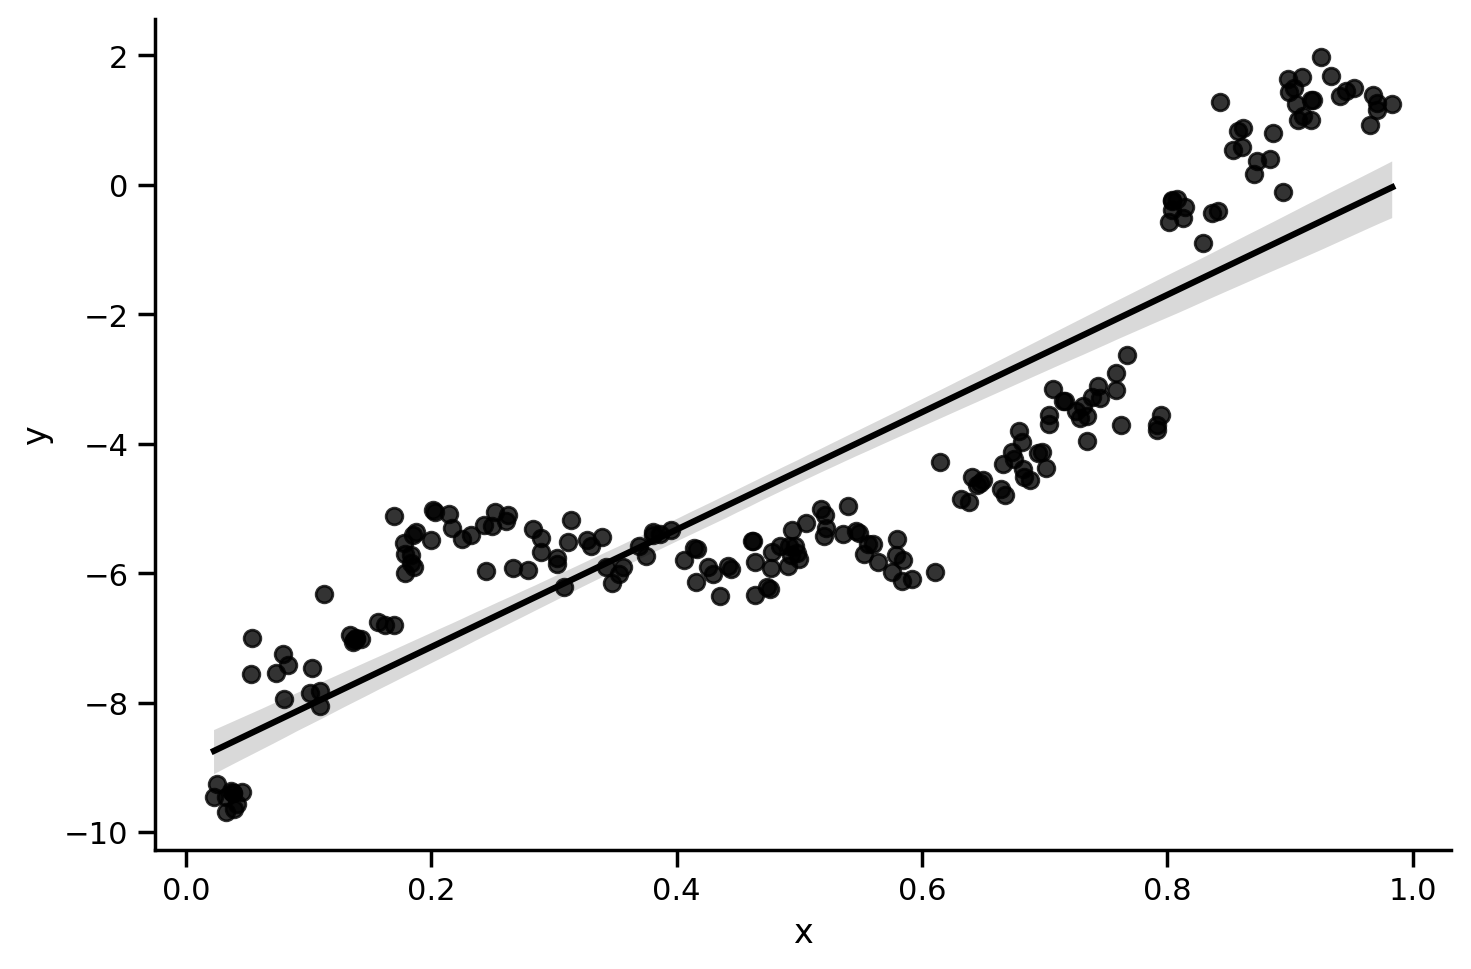

In [3]:
sns.lmplot(data=df_simpson.to_pandas(), x='x', y='y', aspect=1.5, line_kws={'color': 'black'}, scatter_kws={'color': 'black'})

We can estimate the model using `ols()` and see that the overall relationship is **positive** and significant

In [4]:
from statsmodels.formula.api import ols

print(ols('y ~ x', data=df_simpson.to_pandas()).fit().summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
No. Observations:                 200   F-statistic:                     693.0
Covariance Type:            nonrobust   Prob (F-statistic):           1.37e-66
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9538      0.199    -44.949      0.000      -9.347      -8.561
x              9.0688      0.344     26.325      0.000       8.389       9.748

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


Let's take another look at the data using different colors for different participants

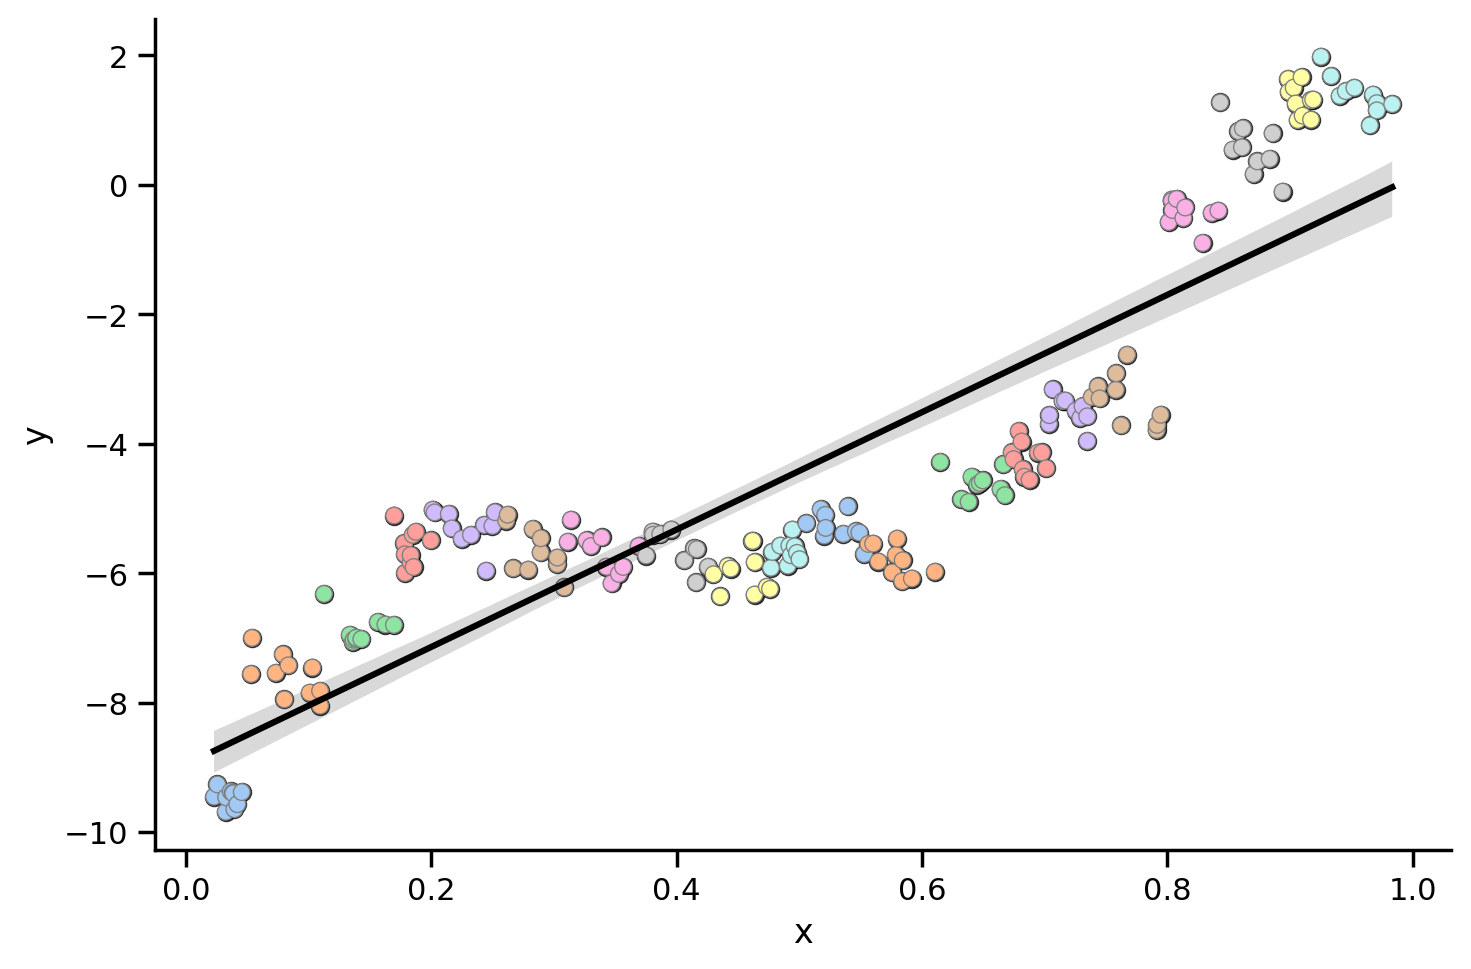

In [5]:
grid = sns.FacetGrid(data=df_simpson.to_pandas(), height=5, aspect=1.5)
grid.map(sns.regplot, 'x', 'y', color='black')
grid.map_dataframe(sns.scatterplot, 'x', 'y', hue='participant', data=df_simpson.to_pandas(), palette='pastel', edgecolor='gray');

And fit a different regression line per particpant:

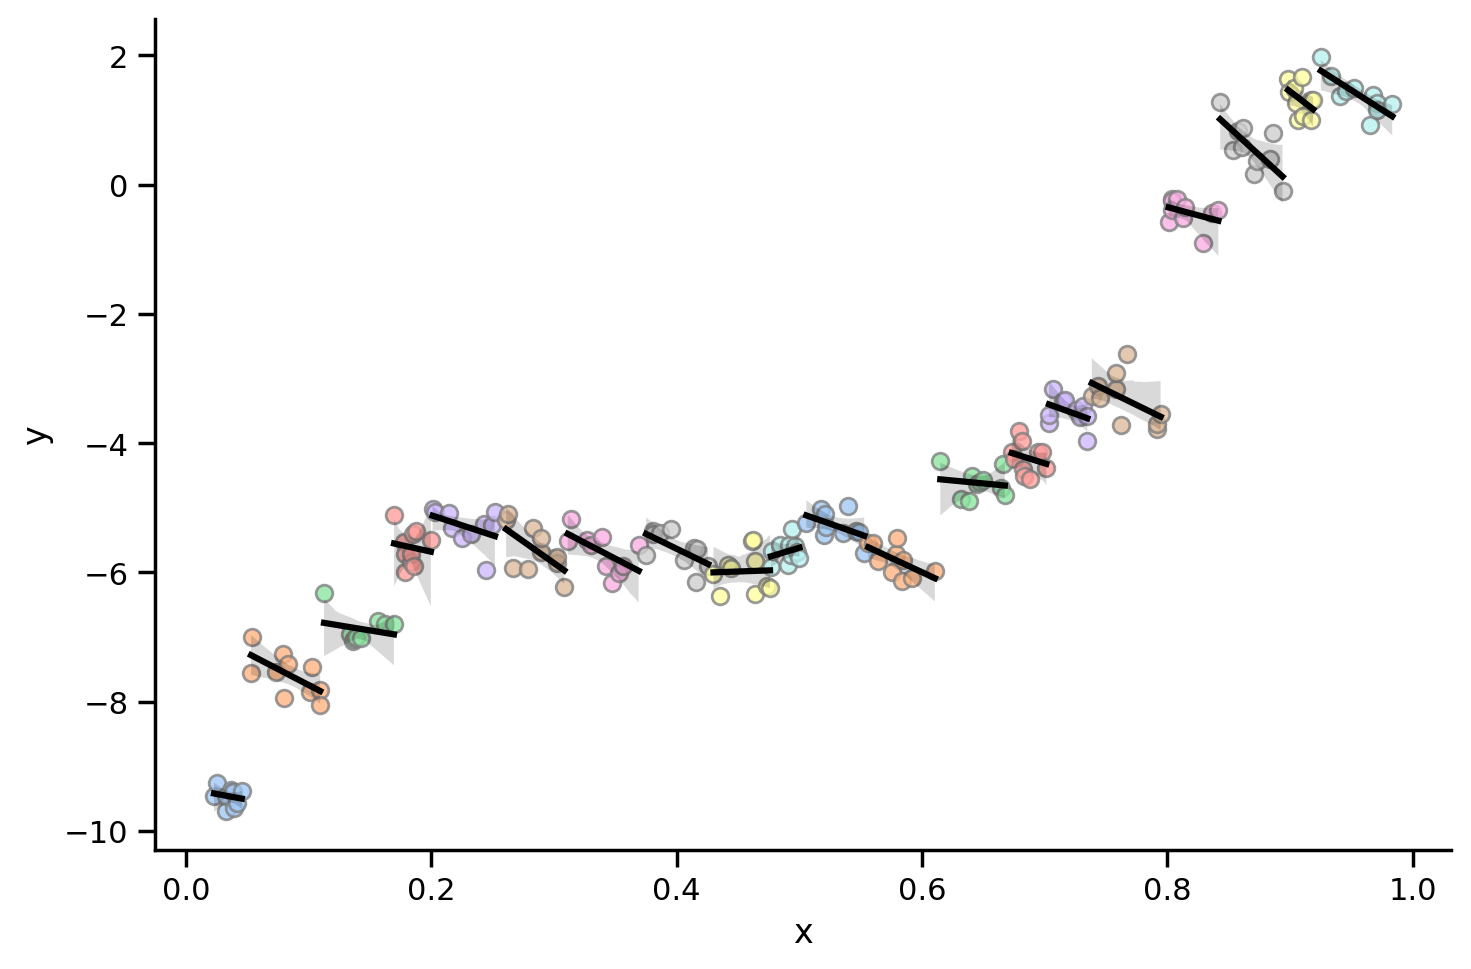

In [6]:
grid = sns.lmplot(data=df_simpson.to_pandas(), x='x', y='y', hue='participant', aspect=1.5, scatter_kws={'edgecolor': 'gray'}, palette='pastel', line_kws={'color': 'black'}, legend=False)

What this plot shows is that for almost all individual participants, the relationship between `x` and `y` is **negative**!

Let's fit an LMM with random intercepts using `pymer4`

We can do so by create a model with a formula and some data using the `Lmer` Python class similar to `ols()` we've been using. We can then call the `.fit()` method on the model with `summarize=True` to get estimated parameters.

This is **different** from `ols()` where, `.fit()` returned a *results* object that we were using for things like `.summary()` and `.parameters`. 

In `pymer4` **everything is contained in the model you create with `Lmer`**  

We'll explore this more in the next section, for now let's take a look at the estimated fixed effect of `x`

In [7]:
from pymer4.models import Lmer

# Create model
model = Lmer('y ~ x + (x | participant)', data=df_simpson.to_pandas())

# Call fit() to estimate parameters; doesn't return anything!
model.fit() 

# Fixed effects and inferential stats
model.coefs

boundary (singular) fit: see help('isSingular') 



Estimate    2.5_ci   97.5_ci        SE        DF    T-stat  \
(Intercept) -0.760196 -3.403647  1.883256  1.348724  13.66477 -0.563640   
x           -6.519442 -8.773135 -4.265749  1.149864  92.86580 -5.669748   

                    P-val  Sig  
(Intercept)  5.821312e-01       
x            1.603694e-07  ***

As we can see, the fixed effect for `x` is now negative!   
We can plot each participant's random effect to see this:

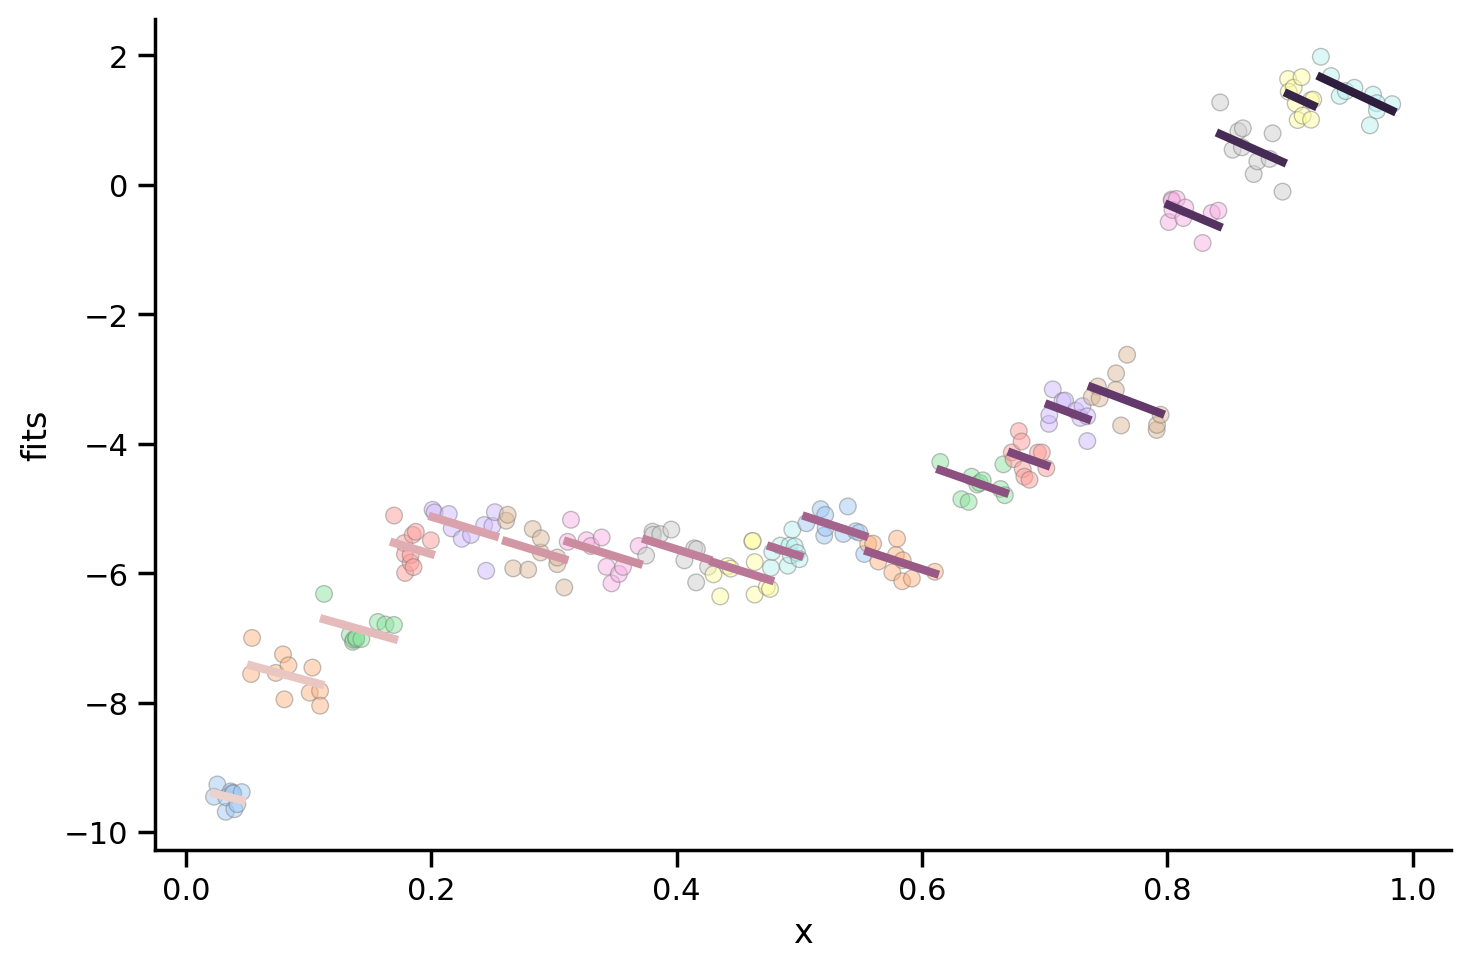

In [8]:
# Scatter plot per subject
grid = sns.FacetGrid(data=model.data, height=5, aspect=1.5)
grid.map_dataframe(sns.scatterplot, 'x', 'y', hue='participant', palette='pastel', edgecolor='gray', alpha=0.5);
grid.map_dataframe(sns.lineplot, 'x', 'fits', hue='participant', estimator=None, linewidth=3, color='black');

## Different ways to handle dependent data

Simpson's paradox shows us that if we don't properly account for violations for independence we run the risk of making incorrect inferences.

In class we discussed 3 approaches for handing dependent data by aggregation:
- **Complete pooling**: just a single global regression ignoring repeated measures
- **No pooling**: a separate regression per cluster of repeated measures
- **Partial pooling**: a linear mixed effects model

*Note: If you want a more causal, accessible (10-15m) reading about this topic, feel free to checkout [this older blog post Eshin wrote about repeated measures](https://eshinjolly.com/2019/02/18/rep_measures/)*


Let's explore this using the Sleep Study data we looked at in class. 

This dataset is included with `lme4` in R with the following details:

> The average reaction time per day (in milliseconds) for subjects in a sleep deprivation study.

> Days 0-1 were adaptation and training (T1/T2), day 2 was baseline (B); sleep deprivation started after day 2.

> These data are from the study described in Belenky et al.  (2003),
> for the most sleep-deprived group (3 hours time-in-bed) and for
> the first 10 days of the study, up to the recovery period.  The
> original study analyzed speed (1/(reaction time)) and treated day
> as a categorical rather than a continuous predictor.

The original paper if you're interested is: 

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L.
Thomas, Helen C. Sing, Daniel P. Redmond, Michael B. Russo and
Thomas J. Balkin (2003) Patterns of performance degradation and
restoration during sleep restriction and subsequent recovery: a
sleep dose-response study. _Journal of Sleep Research_ *12*, 1-12.


Let's load up the data and take a look at the columns it has:


| Variable   | Description                     |
|------------|---------------------------------|
| Subject     | Unique Subject ID              |
| Limit      | Number of Days of sleep deprivation   |
| Reaction     | Subject's Reaction time in ms |

In [9]:
df = pl.read_csv('data/sleep.csv')
df.head()

shape: (5, 3)
┌─────────┬──────┬──────────┐
│ Subject ┆ Days ┆ Reaction │
│ ---     ┆ ---  ┆ ---      │
│ i64     ┆ i64  ┆ f64      │
╞═════════╪══════╪══════════╡
│ 308     ┆ 0    ┆ 249.56   │
│ 308     ┆ 1    ┆ 258.7047 │
│ 308     ┆ 2    ┆ 250.8006 │
│ 308     ┆ 3    ┆ 321.4398 │
│ 308     ┆ 4    ┆ 356.8519 │
└─────────┴──────┴──────────┘

Mini-challenge: How many days of sleep deprivation are there per subject?

In [10]:
# Solution
df.group_by('Subject').len()['len'].unique()

shape: (1,)
Series: 'len' [u32]
[
	10
]

Mini-challenge: How many unique subjects are there?

In [11]:
# Solution
df['Subject'].n_unique()

18

Let's start by visualizing the data. We'll create a `FacetGrid` using seaborn and plot each participant's data on a separate facet

*Note: we're not currently using the full dataset with 2 participants who had incomplete observations*

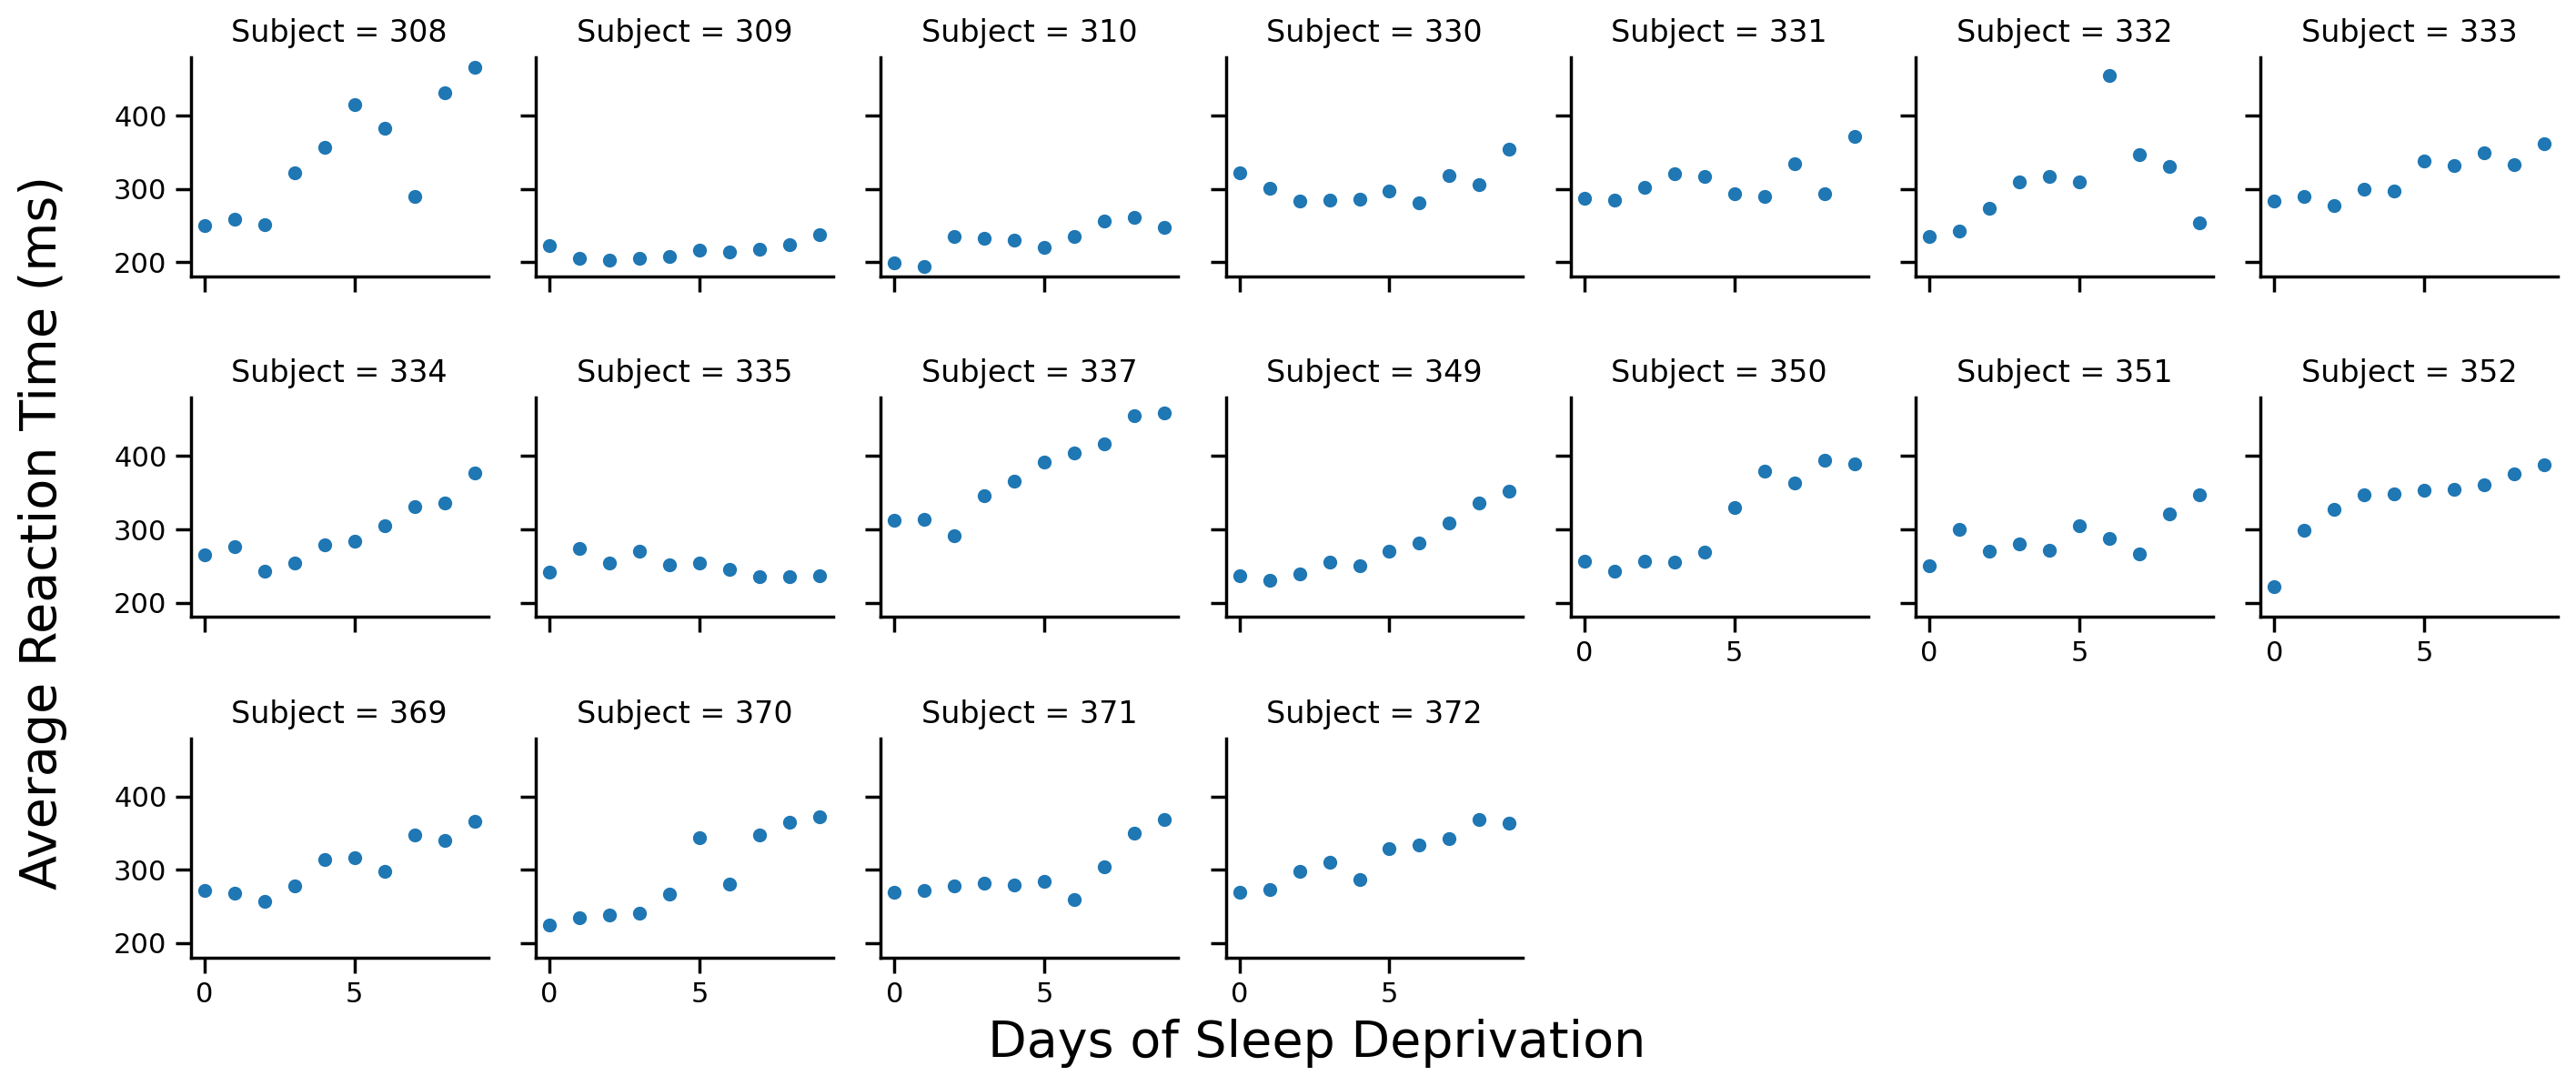

In [12]:
# Scatter plot per subject
grid = sns.FacetGrid(data=df.to_pandas(), col='Subject', col_wrap=7, height=2)
grid.map(sns.scatterplot, 'Days', 'Reaction')

# Labels
grid.set_axis_labels('','')
grid.figure.supxlabel('Days of Sleep Deprivation', fontsize=20)
grid.figure.supylabel('Average Reaction Time (ms)', x=-.01, fontsize=20);

### 1) Complete Pooling: Good 'ole OLS

Complete pooling ignores the fact that we have multiple observations per `Subject` and just fits a regular 'ole regression to all the data

Mini-challenge: Use seaborn to plot the global regression line across all data points

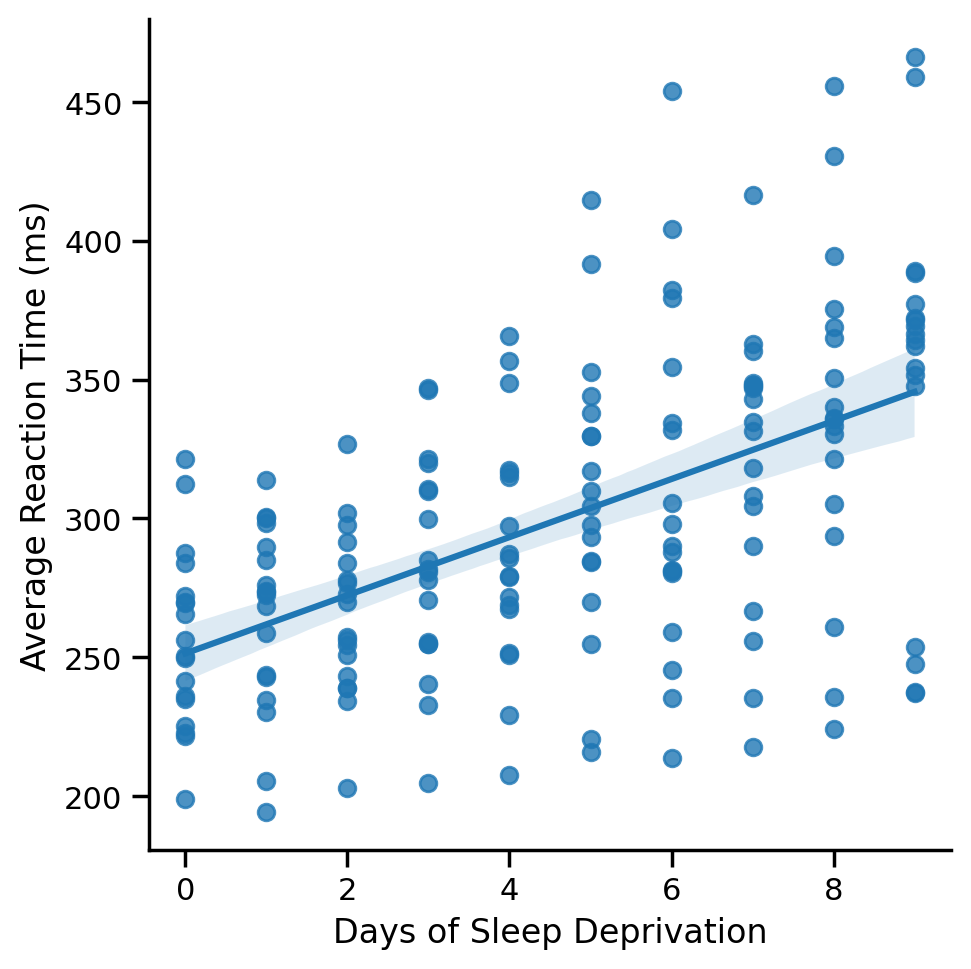

In [13]:
# Solution
grid = sns.lmplot(data=df.to_pandas(), x='Days', y='Reaction')
grid.set_axis_labels("Days of Sleep Deprivation", "Average Reaction Time (ms)");

Min-challenge: Use `ols` to estimate a complete pooling model.  
Save the output of `.fit()` to a variable called `model_cp`

In [14]:
# Solution
model_cp = ols('Reaction ~ Days', data=df.to_pandas()).fit()

If we examine the parameters of the model you fit, we see how just a single intercept and slope is estimate across all subjects.

This is **as if** all the data came from 1 subject!

In [15]:
# Note if this gives you an error, you may have have not saved the output of `.fit()` to a variable called `model_cp`
model_cp.params

Intercept    251.405105
Days          10.467286
dtype: float64

Let's visualize the regression line for each subject. We'll define a helper function below and add it to our `FacetGrid`

In [16]:
# Helper function
def plot_cp(x, **kwargs):
    """Plot a line from slope and intercept of model_cp"""
    intercept = model_cp.params['Intercept']
    slope = model_cp.params['Days']
    y_vals = intercept + slope * x
    plt.plot(x, y_vals, '-', color='k')

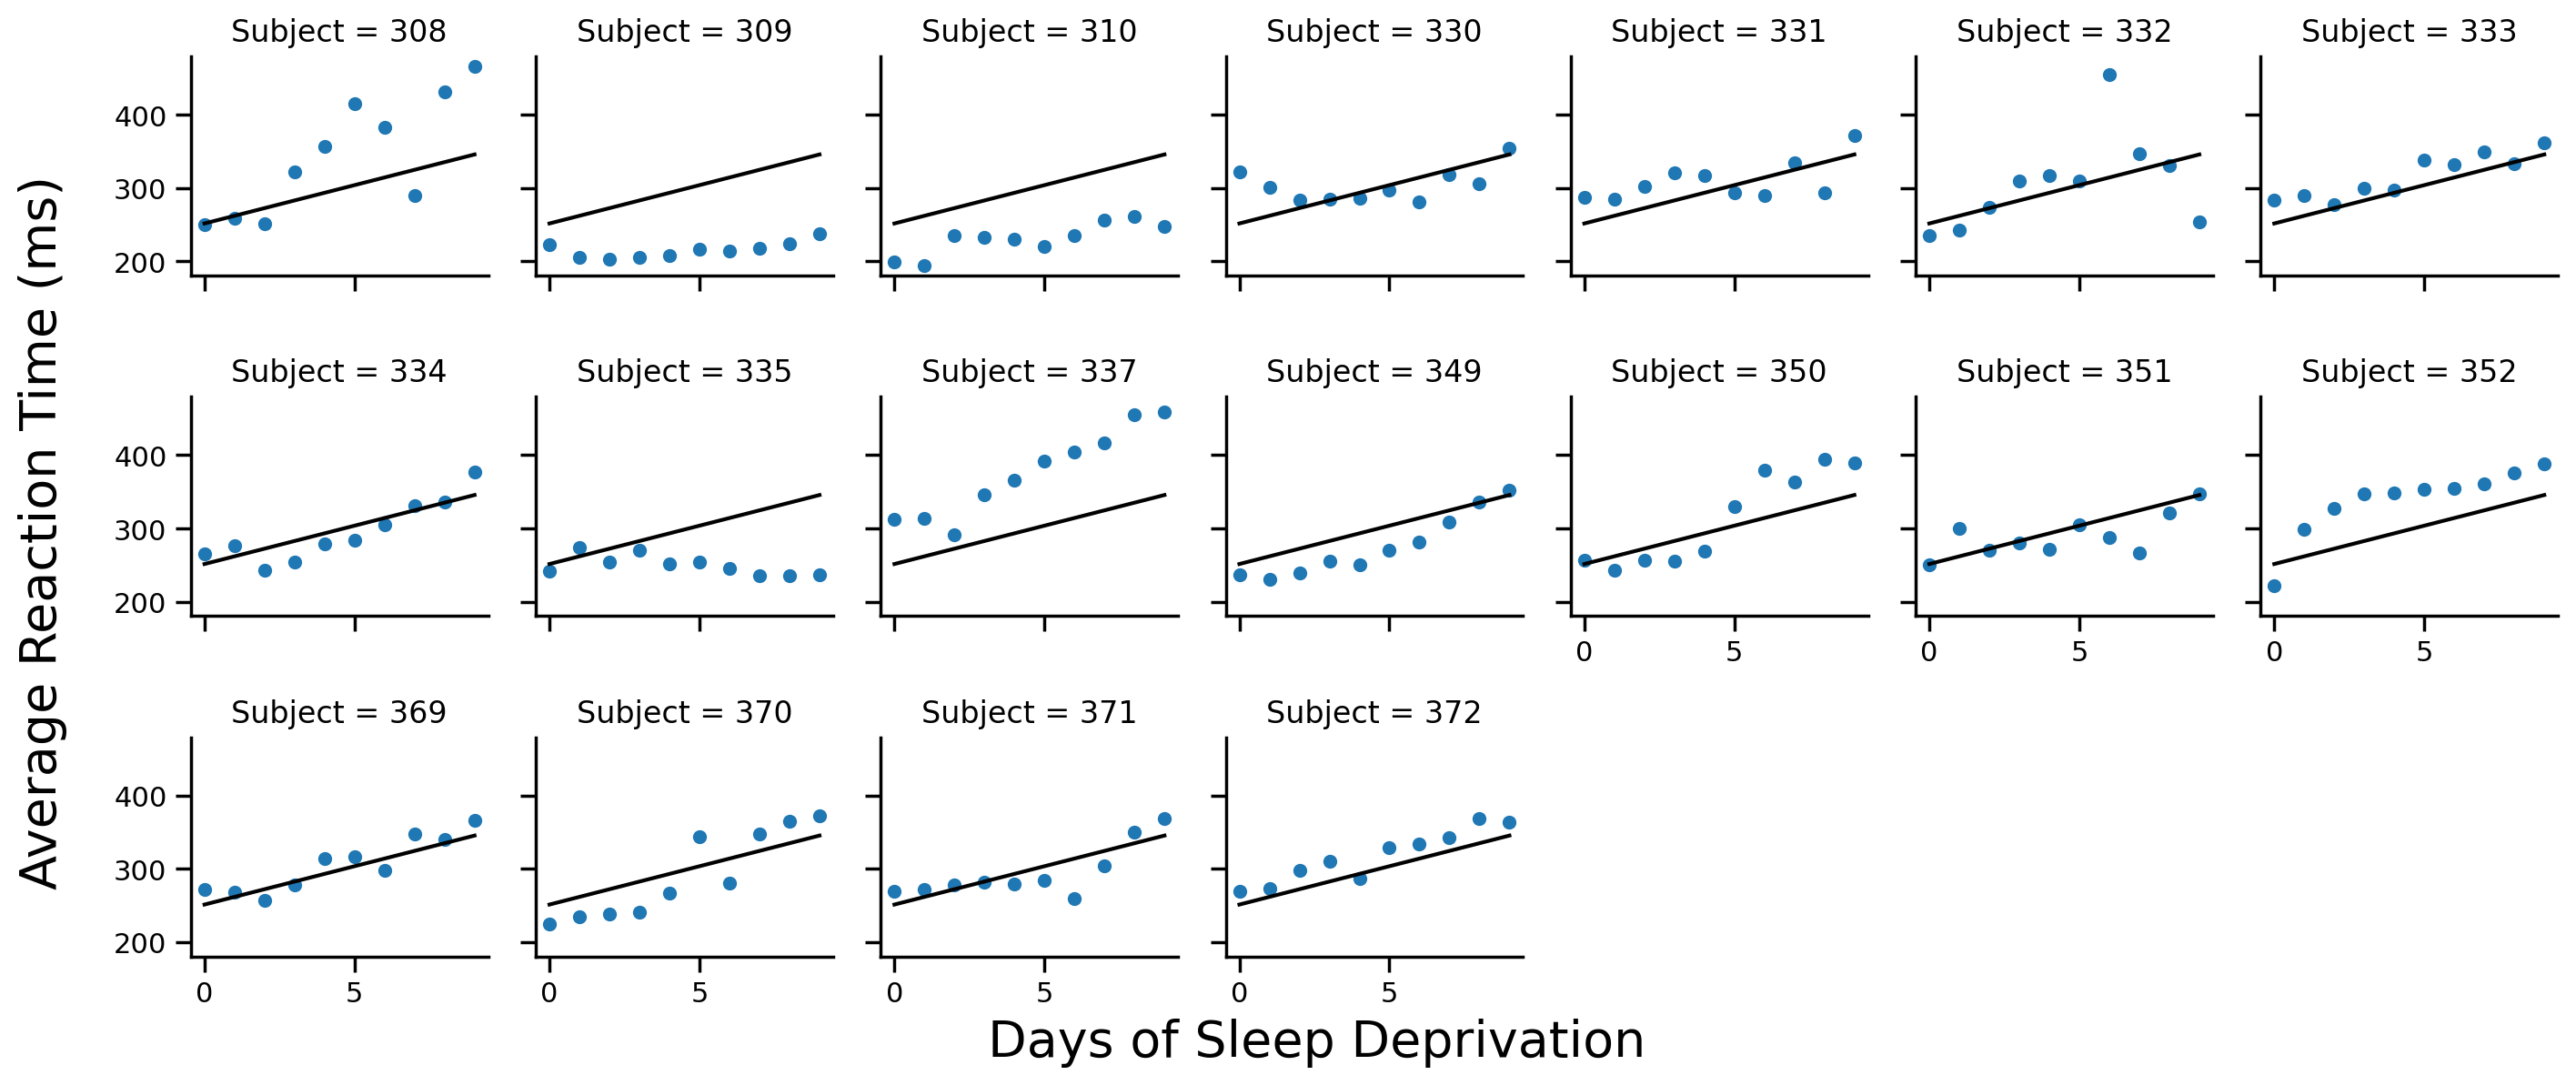

In [17]:
# Scatter plot per subject
grid = sns.FacetGrid(data=df.to_pandas(), col='Subject', col_wrap=7, height=2)
grid.map(sns.scatterplot, 'Days', 'Reaction')

# Add regression line to each subplot
# It's the same for all subjects
grid.map(plot_cp,'Days') 

# Labels
grid.set_axis_labels('','')
grid.figure.supxlabel('Days of Sleep Deprivation', fontsize=20)
grid.figure.supylabel('Average Reaction Time (ms)', x=-.01, fontsize=20);

Notice how each `Subject` has the **same** regression line

### 2) No Pooling: OLS *per* Subject

If we don't pool our data at all, it's like estimating a separate `ols` *per* Subject

`pymer4` includes a special model called `Lm2` that does exactly this. It works just like `ols()` but also takes `group` argument for the variable we should separate the data by and run separate regressions:

In [18]:
# Import it
from pymer4.models import Lm2

# Create model
model_np = Lm2('Reaction ~ Days', group='Subject', data=df.to_pandas())

# Fit it
model_np.fit()

Every model that `pymer4` estimates includes a `.data` attribute with the original data *and* the **fits** and **residuals** from the model:

*Note: data are stored as Dataframe using the pandas library NOT polars that we've been using. Remember you can always convert it into a polars Dataframe by wrapping it in `pl.DataFrame()`. We don't need to do that at the moment as both libraries have a `.head()` method*

In [19]:
model_np.data.head()

Subject  Days  Reaction  residuals        fits
0      308     0  249.5600   5.367331  244.192669
1      308     1  258.7047  -7.252672  265.957372
2      308     2  250.8006 -36.921474  287.722074
3      308     3  321.4398  11.953024  309.486776
4      308     4  356.8519  25.600421  331.251479

We can use this DataFrame to add each Subject's fit to their scatterplot

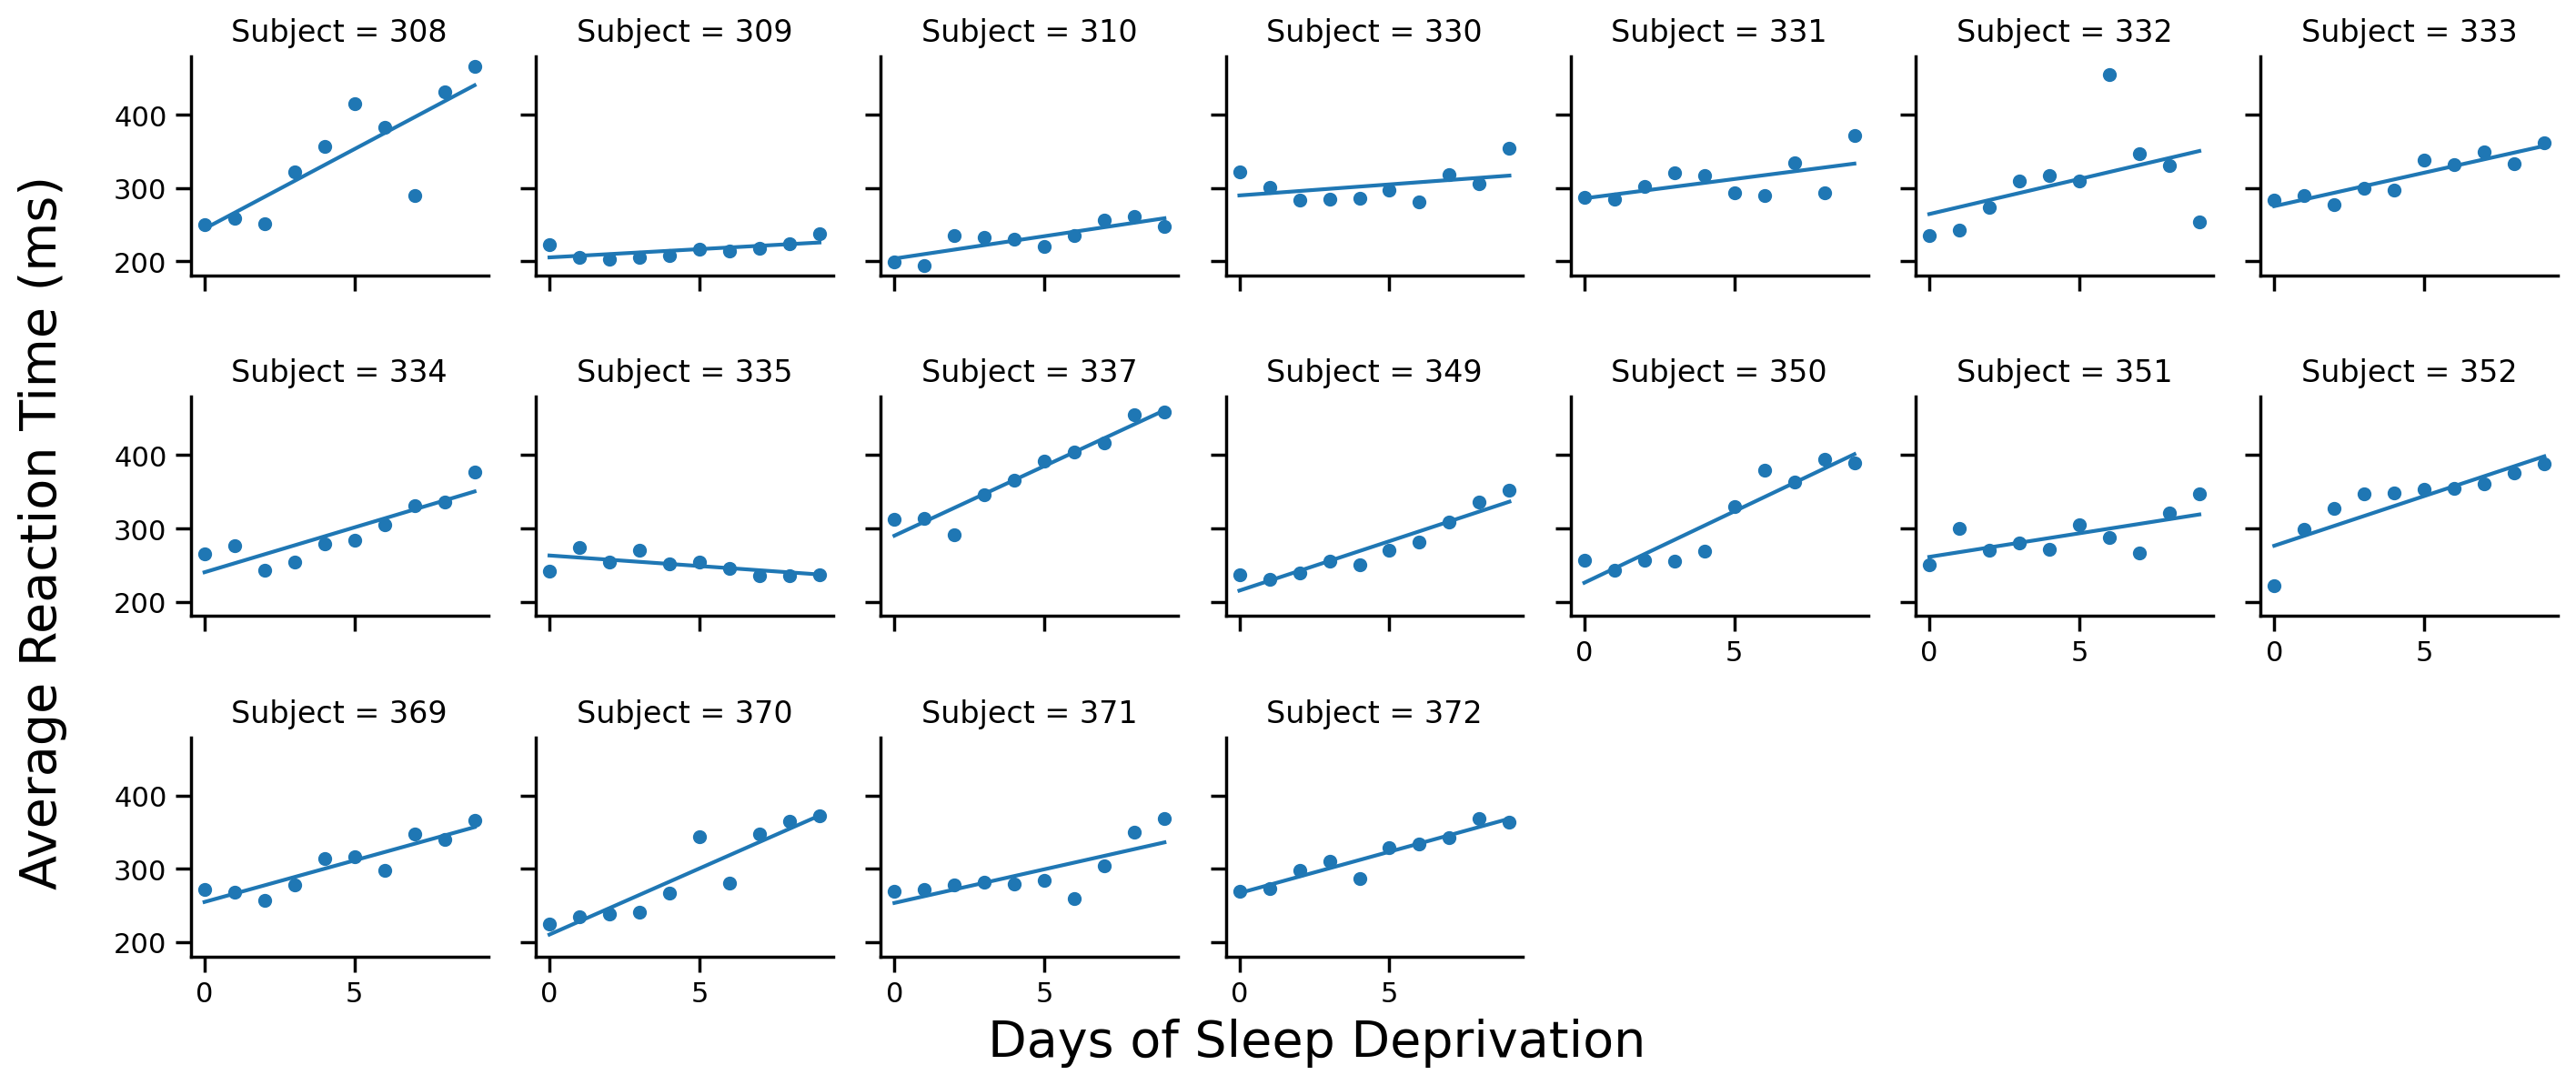

In [20]:
# Scatter plot per subject
grid = sns.FacetGrid(data=model_np.data, col='Subject', col_wrap=7, height=2)
grid.map(sns.scatterplot, 'Days', 'Reaction')

# Add regression line to each subplot
# Now each subject has their own regression line
grid.map(sns.lineplot, 'Days', 'fits')

# Labels
grid.set_axis_labels('','')
grid.figure.supxlabel('Days of Sleep Deprivation', fontsize=20)
grid.figure.supylabel('Average Reaction Time (ms)', x=-.01, fontsize=20);

Mini-challenge: Compare the figure we just made to the one from our complete pooling model. Write a sentence or two on how they're the same or different

*Your response here*

We can also do the same thing by writing a `for` loop and using the  `ols()` function that we're familiar with, but it's a bit more involved:

In [21]:
# To store each subject's parameters and fits/residuals
params = []
fits_resids = []

# Loop over each subject
for subjectID in df['Subject'].unique():
    # Filter data for current subject
    subject_data = df.filter(col('Subject') == subjectID).to_pandas()

    # Fit model
    subject_model = ols('Reaction ~ Days', data=subject_data).fit()

    # Grab subject estimates, add subject ID, and store it
    subject_params = subject_model.params.to_dict()
    subject_params['Subject'] = subjectID
    params.append(subject_params)

    # Grab model fits and residuals and store them
    subject_fits_resids = pl.DataFrame({
        'Subject': np.repeat(subjectID, len(subject_data)),
        'Days': subject_data['Days'].to_numpy(),
        'fits': subject_model.fittedvalues.to_numpy().astype(float), 
        'resid': subject_model.resid.to_numpy().astype(float)})

    fits_resids.append(subject_fits_resids)

# Combine into DataFrames
params = pl.DataFrame(params)[['Subject', 'Intercept', 'Days']]
fits_resids = pl.concat(fits_resids)

# Combine with original data
df_np = df.join(fits_resids, on=['Subject','Days'])

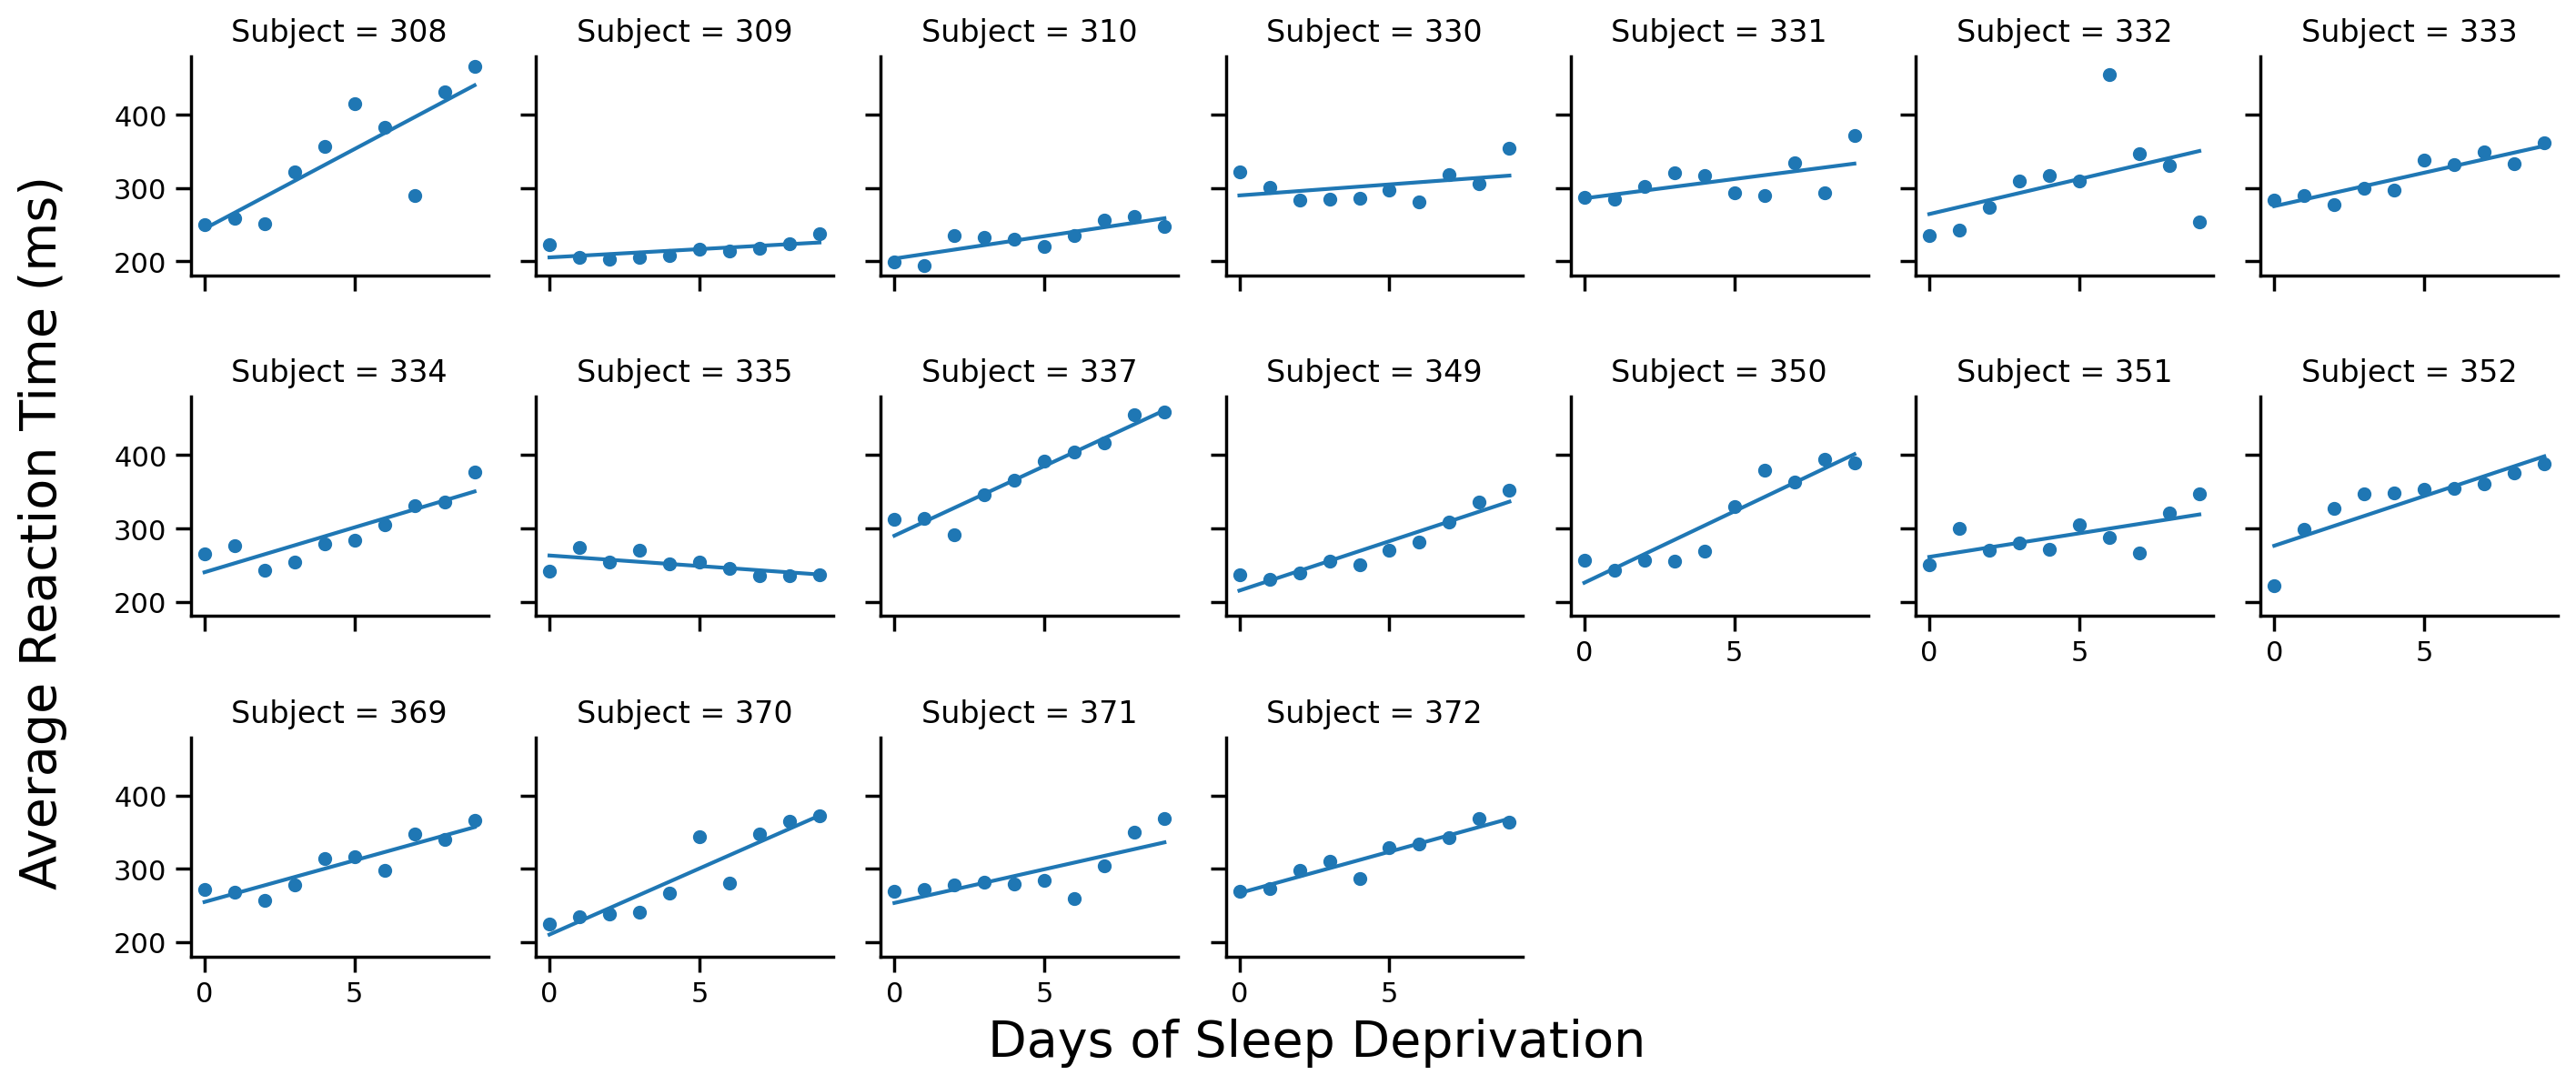

In [22]:
# Scatter plot per subject
grid = sns.FacetGrid(data=df_np.to_pandas(), col='Subject', col_wrap=7, height=2)
grid.map(sns.scatterplot, 'Days', 'Reaction')

# Add regression line to each subplot
# Each subject has their own regression line
grid.map(sns.lineplot, 'Days', 'fits')

# Labels
grid.set_axis_labels('','')
grid.figure.supxlabel('Days of Sleep Deprivation', fontsize=20)
grid.figure.supylabel('Average Reaction Time (ms)', x=-.01, fontsize=20);

### 3) Partial Pooling: Linear Mixed Models

Partial pooling models are the best of both worlds - intuitively you can think about them is half-way between our complete and unpooled approaches.

Instead of ignore or splitting up our dataset, we **explicitly model the dependence** using 2 components:
- **Fixed effects** which capture the general effect we're interested in: $\text{Reaction} \sim \text{Days}$
- **Random effects** which capture the *variance* around the fixed effects; specifically how each Subject's intercept and/or slope deviates from the **fixed effects**

## Linear Mixed Models: Meet `Lmer`

To estimate an LMM we can use the `Lmer()` class from `pymer4`. We provide it a formula and data like before, but this time we also specify the **random effects** we want to estimate using the following syntax

### Random Effects Syntax

<div style="text-align:center";>
<img src="./figs/rfx.png" style="width:600px;">
</div>

### Key Attributes
`Lmer` models have the following attributes that make it easier to work with model results:
- `.coefs` - summary output table; `summary(model)` in R
- `.fixef` - cluster level estimates; `coef(model)` in R
- `.ranef` - cluster level deviances; `ranef(model)` in R
- `.design_matrix` - model design matrix
- `.data` - original data augmented with columns of `fits` and `residuals`

### Random Intercepts Only

Let's estimate an LMM with random intercepts per Subject

Providing `summarize=True` to `.fit()` will automatically print out an R like summary:

In [23]:
from pymer4.models import Lmer

model_pp_i = Lmer('Reaction ~ Days + (1 | Subject)', data=df.to_pandas())
model_pp_i.fit(summarize=True)

Linear mixed model fit by REML [’lmerMod’]
Formula: Reaction~Days+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 180	 Groups: {'Subject': 18.0}

Log-likelihood: -893.233 	 AIC: 1794.465

Random effects:

                 Name       Var     Std
Subject   (Intercept)  1378.179  37.124
Residual                960.457  30.991

No random effect correlations specified

Fixed effects:



Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   251.405  232.302  270.508  9.747   22.81  25.794    0.0  ***
Days           10.467    8.891   12.044  0.804  161.00  13.015    0.0  ***

This outputs lots of information about the model, as well as a classic summary table with t-stats, CIs, and p-values for **fixed effects**:

- Formula: model formula you used
- Family: the type of distribution we're assuming
- Inference: how we're calculating p-values
- Log-likelihood/AIC: measures of model fit that we can use to compare to other models
- Random effects: the variance of the rfx you specified (only intercept in this case)


Using the `.coefs` attribute we can just look at the fixed effects summary.

You'll notice that our degrees-of-freedom are no longer nice round numbers, but include decimal places. That's because `pymer4` uses **both** the `lme4` R library and the `lmerTest` R library which calculate p-values using Satterthwaite approximated degrees of freedom.


In [24]:
model_pp_i.coefs

Estimate      2.5_ci     97.5_ci        SE          DF  \
(Intercept)  251.405105  232.301892  270.508318  9.746716   22.810199   
Days          10.467286    8.891041   12.043531  0.804221  161.000000   

                T-stat         P-val  Sig  
(Intercept)  25.793826  2.241351e-18  ***  
Days         13.015428  6.412601e-27  ***

### Comparing models

We can also compare this to the model-comparison approach we've learned about before

To do this in `pymer4` we use the `lrt()` function which is like the `anova_lm()` function that we're familiar with. Just pass it 1 or models and it will test whether the difference in parameters is **worth it**

In [25]:
from pymer4.stats import lrt

# Drop the Days term
model_pp_null = Lmer('Reaction ~ 1 + (1 | Subject)', data=df.to_pandas())
model_pp_null.fit()

# Compare models to see if including Days as a fixed effect is worth it
lrt(model_pp_null, model_pp_i)

refitting model(s) with ML (instead of REML)


model  npar          AIC          BIC  log-likelihood  \
0     Reaction~1+(1|Subject)     3  1916.541058  1926.119929     -955.270529   
1  Reaction~Days+(1|Subject)     4  1802.078643  1814.850470     -897.039322   

      deviance       Chisq   Df P-val  Sig  
0  1910.541058                              
1  1794.078643  116.462415  1.0   0.0  ***

### Inspecting coefficients

We can inspect the **random effects** using `.ranef` and `.fixef`
- `.ranef`: Subject level deviances from `.coef`
- `.fixef`: Subject level estimates = `.coef` + `.ranef`

Below we see the 20 deviances for the fixed effect intercept term: 1 per Subject

In [26]:
# intercept deviances per subject
model_pp_i.ranef

X.Intercept.
308     40.783710
309    -77.849554
310    -63.108567
330      4.406442
331     10.216189
332      8.221238
333     16.500494
334     -2.996981
335    -45.282127
337     72.182686
349    -21.196249
350     14.111363
351     -7.862221
352     36.378425
369      7.036381
370     -6.362703
371     -3.294273
372     18.115747

And if we combine these with our fixed effects we can calculate our 20 different parameter estimates per Subject, similar to our unpooled approach

Notice that because we only estimated random intercepts, all subjects have the **same slope** for `Days`!

In [27]:
# intercepts and slopes per subject
model_pp_i.fixef

(Intercept)       Days
308   292.188815  10.467286
309   173.555551  10.467286
310   188.296537  10.467286
330   255.811547  10.467286
331   261.621294  10.467286
332   259.626343  10.467286
333   267.905599  10.467286
334   248.408124  10.467286
335   206.122978  10.467286
337   323.587791  10.467286
349   230.208856  10.467286
350   265.516468  10.467286
351   243.542884  10.467286
352   287.783530  10.467286
369   258.441486  10.467286
370   245.042402  10.467286
371   248.110832  10.467286
372   269.520852  10.467286

## Challenge

Using the examples you seen so far try to complete the following challenges

### Random Slopes Only

Reference the Random Effects Syntax table above to estimate a model that only includes **random slopes** per `Subject`

In [28]:
# Solution
model_s = Lmer('Reaction ~ Days + (0 + Days | Subject)', data=df.to_pandas())
model_s.fit()

Using the `.data` attribute of the model and the examples above plot each Subject's data on a different facet along with their estimated regression lines

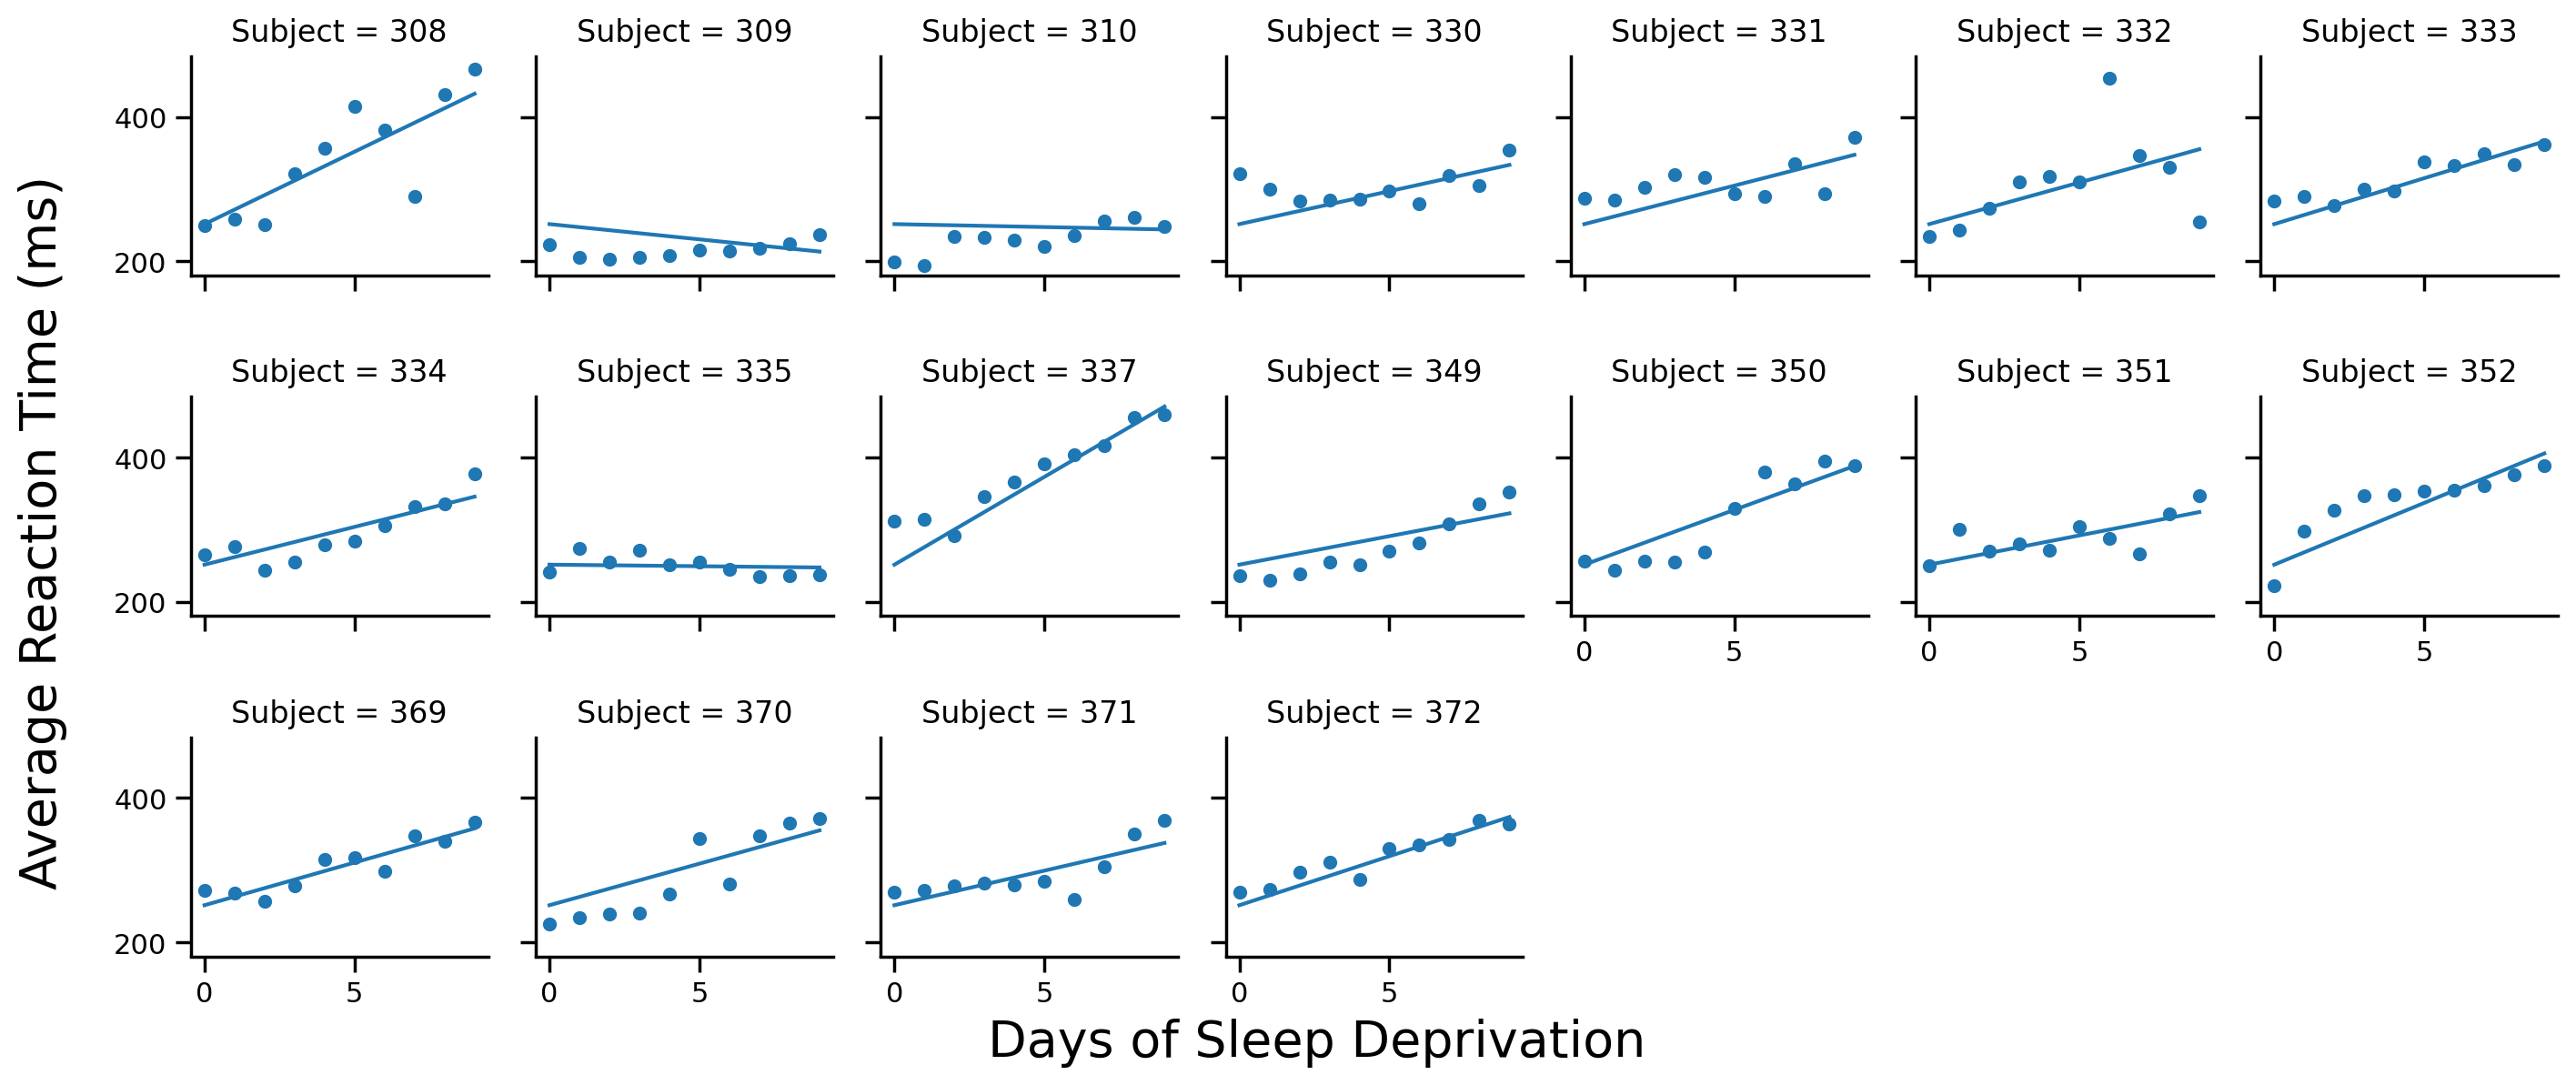

In [29]:
# Solution
# Scatter plot per subject
grid = sns.FacetGrid(data=model_s.data, col='Subject', col_wrap=7, height=2)
grid.map(sns.scatterplot, 'Days', 'Reaction')

# Add regression line to each subplot
grid.map(sns.lineplot, 'Days', 'fits')

# Labels
grid.set_axis_labels('','')
grid.figure.supxlabel('Days of Sleep Deprivation', fontsize=20)
grid.figure.supylabel('Average Reaction Time (ms)', x=-.01, fontsize=20);

### Random Intercepts & Slopes

Reference the Random Effects Syntax table above to estimate a model that includes **correlated random intercepts & slopes** per `Subject`

In [30]:
# Solution
model_is = Lmer('Reaction ~ Days + (1 + Days | Subject)', data=df.to_pandas())
model_is.fit()

Using the `.data` attribute of the model and the examples above plot each Subject's data on a different facet along with their estimated regression lines

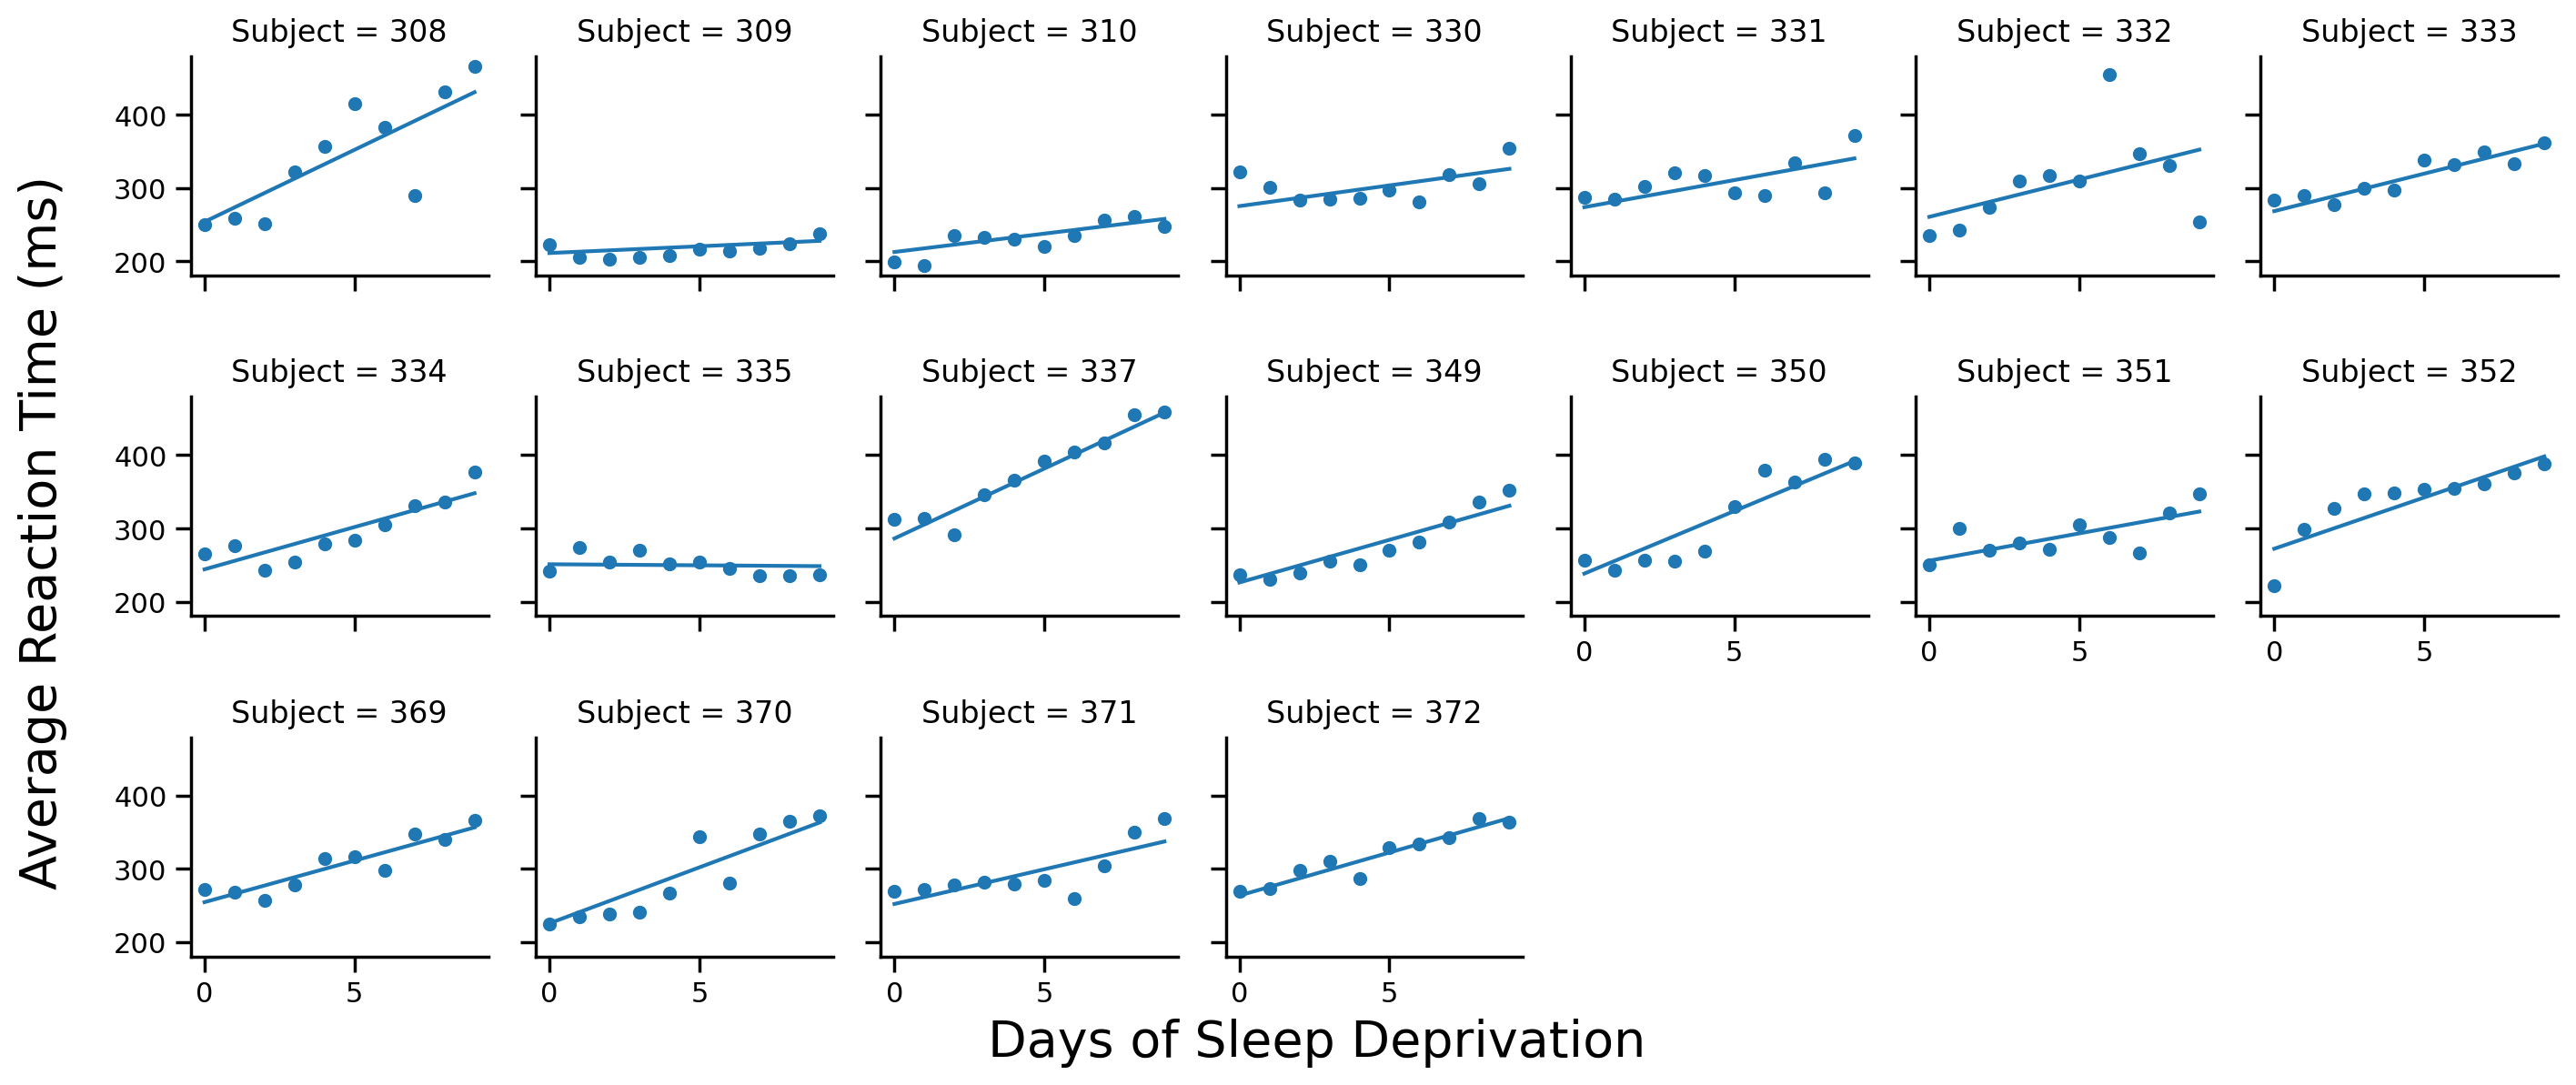

In [32]:
# Solution
# Scatter plot per subject
grid = sns.FacetGrid(data=model_is.data, col='Subject', col_wrap=7, height=2)
grid.map(sns.scatterplot, 'Days', 'Reaction')

# Add regression line to each subplot
grid.map(sns.lineplot, 'Days', 'fits')

# Labels
grid.set_axis_labels('','')
grid.figure.supxlabel('Days of Sleep Deprivation', fontsize=20)
grid.figure.supylabel('Average Reaction Time (ms)', x=-.01, fontsize=20);

### Model Comparison

Using the earlier example as a guide, use the `lrt()` function to compare all 3 mixed effects models. Which random-effects structure seems worth it?

In [33]:
# Your code here
lrt(model_s, model_is)

refitting model(s) with ML (instead of REML)


model  npar          AIC          BIC  \
0  Reaction~Days+(0+Days|Subject)     4  1782.080315  1794.852143   
1  Reaction~Days+(1+Days|Subject)     6  1763.939344  1783.097086   

   log-likelihood     deviance      Chisq   Df     P-val  Sig  
0     -887.040158  1774.080315                                 
1     -875.969672  1751.939344  22.140971  2.0  0.000016  ***

*Your response here*